In [3]:
#import modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
from matplotlib_inline.backend_inline import set_matplotlib_formats
from scipy.integrate import quad

# Set the desired output format
set_matplotlib_formats('svg')

from tol_colors import colorsets
cmap = colorsets['bright']
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm

In [21]:
#Parameters
N=1725881 #population of VGR
pv=0.023 #fraction of cases that are admitted

rho=7*1/5.1 #incubation rate
gamma=7*1/5 #recovery rate
delta = 0.005 # Loss of immunity rate

In [22]:
#the RHS of the SEIR-model
#S=x1
#E=x2
#I=x3
#R=x4
# NOTE: I added loss of immunity to see what happens
def dx(x,t,beta):
    x1, x2, x3, x4= x[0], x[1], x[2], x[3]
    
    dx1 =  -x1*beta*x3/N + delta*x4
    dx2 = x1*beta*x3/N - rho*x2
    dx3 = rho*x2 - gamma*x3
    dx4 = gamma*x3 - delta*x4
    
    return [dx1, dx2, dx3, dx4]

In [23]:
# Example initial conditions
x0 = [N-1, 0, 1, 0]  # [S, E, I, R] at t=0

# Time points for simulation (e.g., 0 to 100 in 0.1 steps)
simulation_time = 1000
t_sim = np.linspace(0, simulation_time, simulation_time+1, endpoint=True)

# Example beta value
beta = 2

# Simulate the system
result = odeint(dx, x0, t_sim, args=(beta,))/N

# result is an array with columns [S, E, I, R] for each time in t_sim

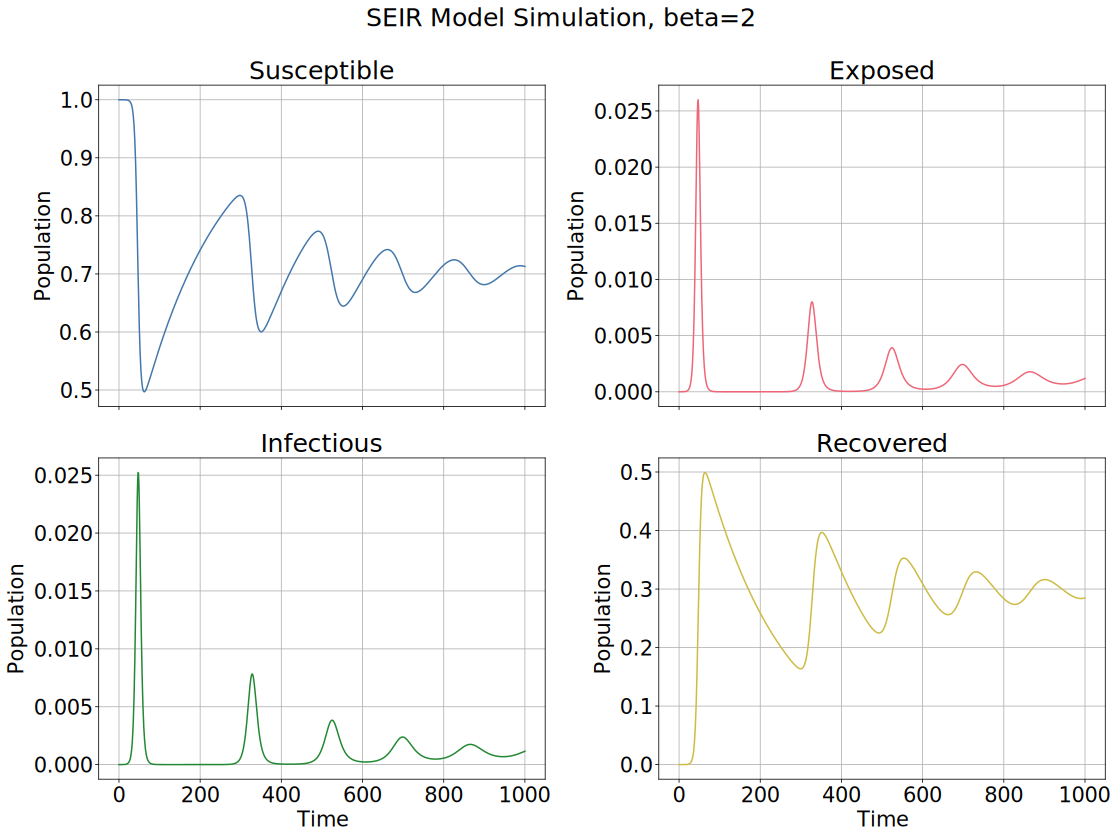

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
axs = axs.flatten()

axs[0].plot(t_sim, result[:, 0], color=cmap[0])
axs[0].set_title('Susceptible')
axs[0].set_ylabel('Population')

axs[1].plot(t_sim, result[:, 1], color=cmap[1])
axs[1].set_title('Exposed')
axs[1].set_ylabel('Population')

axs[2].plot(t_sim, result[:, 2], color=cmap[2])
axs[2].set_title('Infectious')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Population')

axs[3].plot(t_sim, result[:, 3], color=cmap[3])
axs[3].set_title('Recovered')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Population')

for ax in axs:
    ax.grid(True)
fig.suptitle(f'SEIR Model Simulation, beta={beta}')
fig.tight_layout()


In [ ]:
# Initial conditions (S0, E0, I0, R0) - Can adjust if needed, but using a non-zero I0 is typical to start an epidemic
I0 = 1
E0 = 0
R0 = 0
S0 = N - I0 - E0 - R0
x0 = [S0, E0, I0, R0]

# --- Simulation Settings ---
t_sim = np.linspace(0, 10000, 10001) # Simulation time points (increased time for clearer long-term behavior)
transient_time = 700             # Time points to discard as transient
# t_plot is implicitly handled by selecting the end of the solution array

# --- Bifurcation Parameter Range ---
beta_min = 1.8 #0.05
beta_max = 2.8 #5.0
num_betas = 1000 # Increased number of beta values for better resolution

beta_values = np.linspace(beta_min, beta_max, num_betas)

# --- Generate Bifurcation Data ---
# Lists to store beta values and corresponding compartment values for plotting
# Preallocate arrays for efficiency
num_longterm_points = len(t_sim[t_sim >= transient_time])
bifurcation_betas = np.empty(num_betas * num_longterm_points)
S_values = np.empty(num_betas * num_longterm_points)
E_values = np.empty(num_betas * num_longterm_points)
I_values = np.empty(num_betas * num_longterm_points)
R_values = np.empty(num_betas * num_longterm_points)

# Find the index in t_sim where the transient ends
transient_index = np.where(t_sim >= transient_time)[0][0]

ptr = 0
for i, beta in enumerate(tqdm(beta_values, desc='Making bifurcation diagrams')):
    sol = odeint(dx, x0, t_sim, args=(beta,))
    S_longterm = sol[transient_index:, 0]
    E_longterm = sol[transient_index:, 1]
    I_longterm = sol[transient_index:, 2]
    R_longterm = sol[transient_index:, 3]
    n = len(S_longterm)
    bifurcation_betas[ptr:ptr+n] = beta
    S_values[ptr:ptr+n] = S_longterm
    E_values[ptr:ptr+n] = E_longterm
    I_values[ptr:ptr+n] = I_longterm
    R_values[ptr:ptr+n] = R_longterm
    ptr += n

# Truncate arrays to actual used length
bifurcation_betas = bifurcation_betas[:ptr]
S_values = S_values[:ptr]
E_values = E_values[:ptr]
I_values = I_values[:ptr]
R_values = R_values[:ptr]

# --- Plotting the Bifurcation Diagram in Subplots ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

compartment_values = [S_values, E_values, I_values, R_values]
compartment_titles = ['Susceptible (S)', 'Exposed (E)', 'Infected (I)', 'Recovered (R)']

for i, ax in tqdm(enumerate(axes), desc='Plotting', total=4):
    ax.plot(bifurcation_betas, compartment_values[i], ',k', alpha=0.5) # Use ',k' for small black dots
    ax.set_title(f'Long-term {compartment_titles[i]} vs. Beta')
    ax.set_xlabel('Bifurcation Parameter: Beta')
    ax.set_ylabel(compartment_titles[i])
    ax.grid(True, linestyle='--', alpha=0.6)

fig.tight_layout() # Adjust layout to prevent overlapping titles/labels
fig.suptitle('Bifurcation Diagrams for SEIR Model Compartments', y=1.02, fontsize=16) # Add a main title
fig.savefig('plots/bifurcation_diagram_large.pdf')

Making bifurcation diagrams:   0%|          | 0/1000 [00:00<?, ?it/s]

Plotting:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# # Define a range of beta values for the bifurcation diagram
# # Time points for simulation (e.g., 0 to 100 in 0.1 steps)
# t_sim = np.linspace(0, 10000, 1000)
# beta_values = np.linspace(0.5, 30.0, 100)

# # Preallocate numpy arrays for efficiency
# final_S = np.empty_like(beta_values)
# final_E = np.empty_like(beta_values)
# final_I = np.empty_like(beta_values)
# final_R = np.empty_like(beta_values)

# # The current approach only records the final state for each beta,
# # so it cannot capture periodic or oscillatory behavior (e.g., limit cycles).
# # To detect periodicity, you would need to analyze the time series for each beta,
# # for example by checking for oscillations in the last part of the simulation.

# # Example: Store the last N points for each beta to inspect for periodicity
# N_points = 100  # Number of points from the end to analyze
# last_S = np.empty((len(beta_values), N_points))
# last_E = np.empty((len(beta_values), N_points))
# last_I = np.empty((len(beta_values), N_points))
# last_R = np.empty((len(beta_values), N_points))

# for idx, beta_val in enumerate(beta_values):
#     sol = odeint(dx, x0, t_sim, args=(beta_val,))/N
#     final_S[idx] = sol[-1, 0]
#     final_E[idx] = sol[-1, 1]
#     final_I[idx] = sol[-1, 2]
#     final_R[idx] = sol[-1, 3]
#     last_S[idx, :] = sol[-N_points:, 0]
#     last_E[idx, :] = sol[-N_points:, 1]
#     last_I[idx, :] = sol[-N_points:, 2]
#     last_R[idx, :] = sol[-N_points:, 3]

# # You can now analyze last_S, last_E, last_I, last_R for oscillations or plot them for selected beta values.


# fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
# axs = axs.flatten()

# axs[0].plot(beta_values, final_S, color='tab:blue')
# axs[0].set_title('Susceptible (S)')
# axs[0].set_ylabel('Final Size')

# axs[1].plot(beta_values, final_E, color='tab:orange')
# axs[1].set_title('Exposed (E)')
# axs[1].set_ylabel('Final Size')

# axs[2].plot(beta_values, final_I, color='tab:red')
# axs[2].set_title('Infectious (I)')
# axs[2].set_xlabel('Beta (Transmission Rate)')
# axs[2].set_ylabel('Final Size')

# axs[3].plot(beta_values, final_R, color='tab:green')
# axs[3].set_title('Recovered (R)')
# axs[3].set_xlabel('Beta (Transmission Rate)')
# axs[3].set_ylabel('Final Size')

# for ax in axs:
#     ax.grid(True)
# fig.suptitle('Bifurcation Diagram of SEIR Model')
# fig.tight_layout()
